# Optimization of a robotic crane in a chocolate factory
This hands-on exercise is in connection with the session on "Trends in robotics and autonomy" in the Digital Systems course arranged by SINTEFskolen and Digital Academy.  

Optimization is an important area of robotics. Methods and algorithms for optimization helps us to, e.g., reduce energy usage, increase performance, and increase accuracy in robot operations. In this hands-on exercise we give an example on how optimization can be used in robotics and some of the important aspects of optimization – such as "cost functions" and "constraints". You'll learn about cost functions, constraints and more in the rest of this exercise.

**Learning goals:**  
- Understand that a *mathematical model* of a robot (in this case a crane) can be used to produce optimal control algorithms for planning and control.
- Understand the concept of *cost functions* and *constraints* in optimization problems and what they can be used for.

---

<div class="alert alert-block alert-info">
This is an online Jupyter notebook. Notebooks integrate Python code, text and plots in a single convenient file, split into "cells".
Use the "Run" button (or press shift+enter) to step through the code below. It is important that ALL cells are run in sequence.

Note: if the notebook is inactive for some time the process that runs the notebook will disconnect and you will get a "kernel dead" message (this is because the code runs on a server in the cloud somewhere and disconnect to free up resources if you are not using it). If this happens, just simply press "restart" and run through the code from the top again.
</div>

---

### Introducing the problem:
Imagine you are in Willy Wonka's chocolate factory and that there is a big overhead crane operating from the ceiling in one of the production facilities. The crane is big and heavy, and it is therefore very important that the tip of the crane is accurately controlled to avoid bumping into Oompa Loompas, squirrels and other workers inside the factory, while at the same time contributing to achieving fast and efficient production.  

To this end, for this hands-on task we will consider using <mark>trajectory optimization</mark> to control the overhead crane. The crane has a overhead cart with horizontal position called $r$ and an angle $\theta$ down to the payload hanger of the crane, as seen in the figure below. The crane has velocity $\dot{r}$ and the payload has an angular velocity $\dot{\theta}$. We can push the "cart" with a force $F$ and will try to find a way to decide $F$ over time such that we move the crane system from the "Start" position to the "Target" position while minimizing speed and force. 

<img src="crane_fig.png" alt="crane" width="800"/>

### Trajectory optimization:

<!-- *Need to show problem we are formulating and explain NLPs briefly* -->

<!-- \begin{aligned}
    \min_{u} \quad & \sum_{i=0}^{N-1}{R_r (r_i - r_t)^2 + R_\theta \theta_i^2} + R_{\dot{r}} \dot{r}_i^2 + R_{\dot{\theta}} \dot{\theta}_i^2 \\
    \textrm{s.t.} \quad & x_{k+1} = f_d(x_k, u_k) \quad \forall k = 0, 1, \dots, N-1 \\
    & x_0 = x(k)    \\
\end{aligned} -->

<div class="alert alert-block alert-warning">
<b>Trajectory optimization, briefly:</b>
Optimization is a general framework for minimizing/maximizing some function (subsequently called a cost function), while adhering to constraints. In trajectory optimization we apply optimization to find some optimal trajectory/path for a system, such as a robot, drone, rocket, or in our case, crane. By designing a cost function such that some performance metric for the system is minimized, while considering the dynamics of our system and possibly additional constraints, this can be achieved.
</div>

For our first example we will simply tell the optimizer to minimize the distance to our target position. We write this mathematically like this:
$$R_r (r - r_t)^2 + R_\theta \theta^2.$$

This function is called a *cost function* and since this function is to be minimized, the optimization system will simultaneously try to bring the horizontal position of the cart $r$ to the target $r_t$, while also bringing the angle $\theta$ to the down position (zero). $R_r$ and $R_\theta$ are weights that describe how we weigh these two goals against each other. I.e., if $R_r$ is much bigger than $R_\theta$, then the crane trajectory optimizer will prioritize getting the cart to the target position, and give less priority to getting the crane angle to zero.  

We will minimize this cost function over a time horizon of 4 seconds – i.e., our crane trajectory optimizer will look up to 4 seconds into the future and optimize the crane movement for this time period. We could have set a longer period, but this would have required more compute power in order to solve the optimization problem.

A key to optimization is to understand how a system will behave. To this end, we need to make a mathematical model of the crane systems. This mathematical model is given to our trajectory optimizer, such that it can take into account how the crane will move when it plans our desired motion.

Now let's add some code to do this. There is no need to read through the code to follow the main aspects this hands-on exercise.

First we need some imports and other boilerplate things:

In [4]:
# Enable nice plots:
%matplotlib inline

# Imports:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import rcParams, animation
import casadi as cs

# Center figures:
from IPython.core.display import HTML
HTML("""
<style>
.output_subarea {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Then the mathematical model of our crane system is defined:

In [5]:
# Create symbolic variables for the state variables and input variable:
r = cs.MX.sym('r')
theta = cs.MX.sym('theta')
r_dot = cs.MX.sym('r_dot')
theta_dot = cs.MX.sym('theta_dot')
x = cs.vertcat(r, theta, r_dot, theta_dot)  # x is the vector of the 4 states: x = [r, theta, r_dot, theta_dot]
u = cs.MX.sym('F')  # is the input, i.e., the force F

m_1 = 5.0  # mass of the cart
m_2 = 1.0  # mass of the payload
l = 1.0    # length of the pendulum
g = 9.81   # gravity

M_inv = cs.MX(2,2)  # inverse mass matrix
M_inv[0,0] = m_2 * l**2
M_inv[0,1] = - m_2 * l * cs.cos(theta)
M_inv[1,0] = - m_2 * l * cs.cos(theta)
M_inv[1,1] = m_1 + m_2
M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

h = cs.MX(2,1)  # gravity + coriolis terms
h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
h[1,0] = m_2 * l * g * cs.sin(theta)

x_dot = cs.vertcat(x[2:], M_inv @ (cs.vertcat(u, 0) - h))  # formulate dynamics / time derivative of states
f = cs.Function('f', [x, u], [x_dot])

In [6]:
# We integrate the dynamics over time to get the states over time using the Runge-Kutta 4 method:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

dt = 0.05  # optimizer time step
f_d = cs.Function('f', [x, u], [integrate_RK4(x, u, f, dt)])  # discrete dynamics

As with many other things in life (machine learning, filtering, etc.) there are very good software libraries available also for optimization. We have chosen to use a library called CasADi (https://web.casadi.org/) for writing code to optimize the crane trajectory. This is done as follows (again, there's no need for you to read the code, but remember to run it):

In [7]:
N = 80      # number of control segments
r_t = 0.5   # target position

def optimize_crane(N, x_0, r_t, R_F=0, use_term_constraint=False, F_max=None, theta_max=None):
    # Weights:
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    if F_max is None: F_max = cs.inf

    # Objective function:
    J_k = cs.Function('J_k', [x, u], [R_r*(x[0] - r_t)**2 + R_theta*x[1]**2 + R_r_dot*x[2]**2 + R_theta_dot*x[3]**2 + R_F*u**2])

    # Start with an empty NLP (nonlinear program):
    w = []
    w0 = np.zeros(N)
    lbw = []
    ubw = []
    J = 0
    g = []
    lbg = []
    ubg = []

    X_k = cs.MX(x_0)
    for k in range(N):
        # Control input at step k:
        U_k = cs.MX.sym('U_' + str(k))
        w += [U_k]
        
        # Add control input constraints:
        lbw += [-F_max]
        ubw += [F_max]

        X_k = f_d(X_k, U_k)  # integrate to get state at time step k
        J += dt * J_k(X_k, U_k)  # add cost at time step k to cost over entire time horizon

        # Add state constraint:
        if theta_max is not None:
            g += [X_k[1]]
            lbg += [-theta_max]
            ubg += [theta_max]

    # Add terminal constraint:
    if use_term_constraint:
        g += [X_k[0] - r_t]
        g += [X_k[1:]]
        lbg += [0, 0, 0, 0]
        ubg += [0, 0, 0, 0]

    # Create an NLP solver:
    nlp = {'f': J, 'x': cs.vertcat(*w), 'g': cs.vertcat(*g)}
    opts = {'ipopt.print_level':0, 'print_time':0}
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

    # Solve the NLP:
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    u_sol = sol['x']
    return u_sol

We then add some code for simulating the crane (i.e., to calculate the dynamics of the crane over time based on the mathematical model of the crane we defined in one of the code blocks above): 

In [8]:
N_sim = 1000                            # number of simulation steps 
dt_sim = 0.005                          # time step of simulation in seconds 
x_0 = np.array([-0.5, 0.0, 0.0, 0.0])   # initial state (r, theta, r_dot, theta_dot)

def simulate_crane(x_0, u):
    k_u = int(dt/dt_sim)
    x_sim = np.zeros((N_sim+1,4))
    x_sim[0,:] = x_0
    u_sim = np.zeros(N_sim)
    for k in range(N_sim):
        if k < k_u * N: u_sim[k] = u[int(k/k_u)]
        x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()
    return x_sim, u_sim

Finally we need some code for plotting/visualizing the simulation results:

In [9]:
from IPython.display import HTML

rcParams['lines.linewidth'] = 2

def plot_results(x_sim, u_sim, F_max=None, theta_max=None):
    t = np.array([dt_sim*i for i in range(N_sim)])
    
    # Plot control input:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.step(t, u_sim, where='post', c='teal')
    if F_max is not None:
        ax.plot([0, np.max(t)], F_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
        ax.plot([0, np.max(t)], -F_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
    ax.set_title('Force input')
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$F$ (N)')

    # Plot state variables:
    fig, ax = plt.subplots(2,2, figsize=(10,5))
    fig.suptitle('States')
    
    ax[0,0].plot(t, x_sim[:N_sim,0], c='mediumblue')
    ax[0,0].plot([0, np.max(t)], r_t * np.ones(2), '--', c='crimson', alpha=0.7)
    ax[0,0].set_ylabel(r'$r$ (m)')
    ax[0,0].set_xlabel(r'$t$ (s)')
    
    ax[0,1].plot(t, x_sim[:N_sim,1], c='mediumblue')
    ax[0,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    if theta_max is not None:
        ax[0,1].plot([0, np.max(t)], theta_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
        ax[0,1].plot([0, np.max(t)], -theta_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
    ax[0,1].set_ylabel(r'$\theta$ (rad)')
    ax[0,1].set_xlabel(r'$t$ (s)')

    ax[1,0].plot(t, x_sim[:N_sim,2], c='mediumblue')
    ax[1,0].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    ax[1,0].set_ylabel(r'$\dot{r}$ (m/s)')
    ax[1,0].set_xlabel(r'$t$ (s)')
    
    ax[1,1].plot(t, x_sim[:N_sim,3], c='mediumblue')
    ax[1,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    ax[1,1].set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax[1,1].set_xlabel(r'$t$ (s)')

    plt.show()

def show_animation():
    skips = 10
    frames = int(N_sim / skips)
    delay = skips*dt_sim*1e3

    rect_height = 0.15
    beam_height = 0.05
    radius = 750

    fig, ax = plt.subplots(figsize=(8,5))

    line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', alpha=0.7, lw=1.5)
    rect_1 = ax.add_patch(Rectangle((-1, -0.5*beam_height), 2, beam_height, facecolor='firebrick', edgecolor='k', lw=2))
    rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.5*rect_height), 0.4, rect_height, facecolor='indianred', edgecolor='k', lw=2))

    x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
    y_pendulum = -l * np.cos(x_sim[0,1])
    line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
    point_1 = ax.scatter(x_pendulum, y_pendulum, s=radius, facecolors='darkorange', edgecolors='k', lw=2)

    line_3, = ax.plot([-0.5, -0.5], [-1,0], 'k--', alpha=0.7, lw=1.5)
    line_4, = ax.plot([0.5, 0.5], [-1,0], 'k--', alpha=0.7, lw=1.5)

    plt.axis('equal')
    plt.xlim([-1, 1])
    plt.ylim([-1.35, 0.35])

    def animate(i):
        rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
        
        x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
        y_pendulum = -l * np.cos(x_sim[skips*i,1])
        
        point_1.set_offsets([x_pendulum, y_pendulum])
        line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
        
        return line_2, point_1, rect_2
    
    plt.close()

    return animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

Now we can try to optimize the crane trajectory such that we bring the crane to the target position, and simulate and plot the results:


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



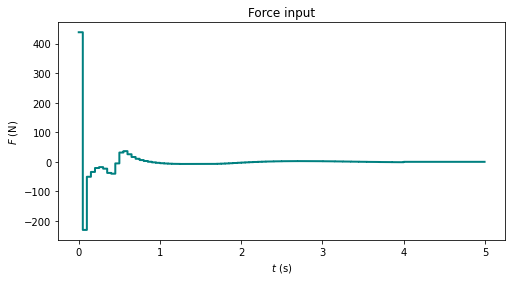

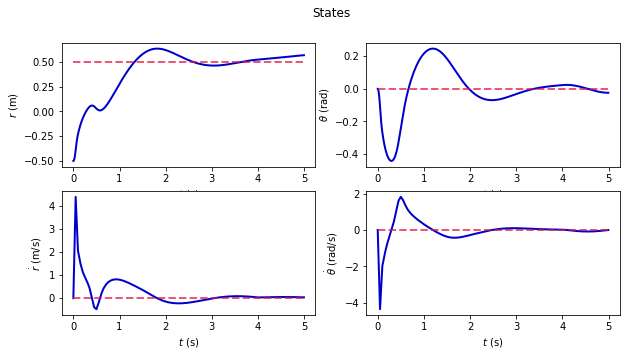

In [10]:
F_opt = optimize_crane(N, x_0, r_t)         # find the optimal force over time F_opt
x_sim, u_sim = simulate_crane(x_0, F_opt)   # simulate the crane system using F_opt to control the crane
plot_results(x_sim, u_sim)                  # plot the simulation results

Run the next cell to display the crane animation (it takes a few seconds):

In [11]:
HTML(show_animation().to_jshtml())

Let's pause here for a bit and have a look at the above plots and the animation.

- The top plot ("Force input") shows the force applied to the cart-module of the crane.
- The two left-most figures show the position and the speed of the cart.
- The two right-most figures shows the angle and angular velocity of the payload of the crane.

So, that didn't go too well in terms of stabilizing the crane and its payload. We see from the plots that the payload of the crane does not fully stabilize in it's target position.

We also see that initially the crane jumps forward with a very large force. This would not be good for our crane and would probably not pass the safety requirements at the chocolate factory.

So far we have only told the optimizer to minimize the distance to target for the cart and the angle to target for the payload by adding an expression for these two in the cost function of the optimizer. But we see from the above example that we should also try to minimize how large force we are using to push the cart with. This will hopefully give us smoother and safer (for the Oompa Loompas) crane motions. This can be achieved by adding the term $R_F F^2$ to the cost function. The new cost function then looks like this:
$$R_r (r - r_t)^2 + R_\theta \theta^2 + R_F F^2$$

Try to change the value of the weight (to e.g. 0.01, 0.1, 1, 10,...) in the code block below and see how it affects the resulting motion. Try to find a suitable value that weights the two tasks against each other appropriately.

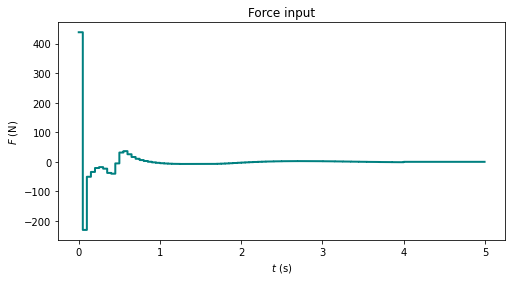

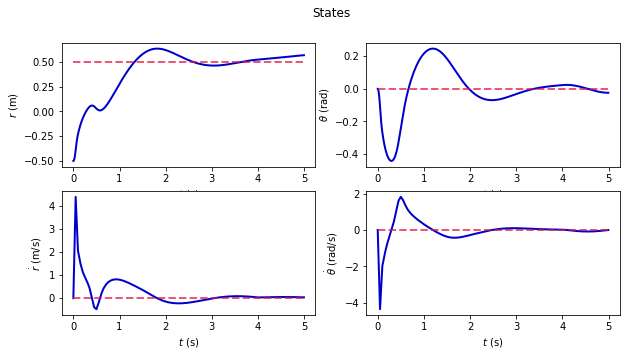

In [12]:
### Try to change the force weight and see the effect:

force_weight = 0.0

###

F_opt = optimize_crane(N, x_0, r_t, R_F=force_weight)
x_sim, u_sim = simulate_crane(x_0, F_opt)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

That hopefully looks much smoother. For the remaining tests we will use a weight of 0.1.

***

### Adding a terminal constraint:
But we have another problem: the crane pendulum doesn't hit our target exactly! It wiggles around, but ideally we want it to end perfectly at rest at its target position.

One way of solving this is to add a <mark>terminal constraint</mark>. This means that we constrain the position and angle of our crane on the final time step at $t = 4s$ to be exactly at the target, while also saying that the final velocity should be zero. This can be written like:
$$r_f = r_t, \quad \theta_f = 0, \quad v_f = \omega_f = 0,$$
where $r_f$ and $\theta_f$ are the final position and final angle, respectively, and $v_f$ and $\omega_f$ are the final linear and angular velocity, respectively.

Let's try out the example again, now with the terminal constraint added:

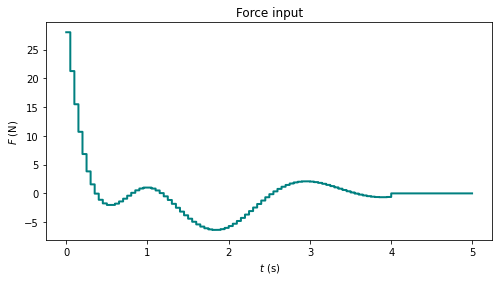

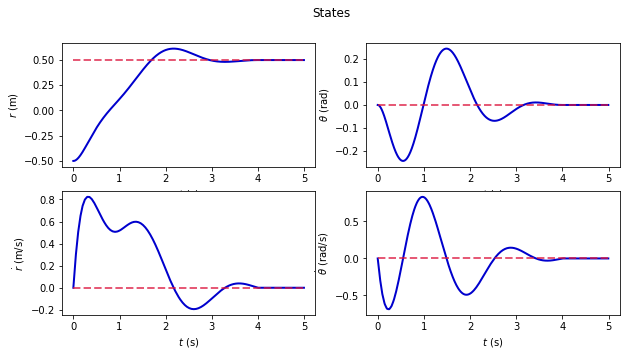

In [13]:
force_weight = 0.1
F_opt = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, F_opt)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

Now we are getting somewhere! It ends perfectly at rest in the target position!

***

### Adding input constraints:

Ok, but what if we have a *finite* maximum force we can push the overhead cart with? One of the main reasons why optimization is so popular in robotics applications is that such constraints can be seamlessly added to the optimization problem!

We add constraints on the form:
$$-F_{\textrm{max}} \leq F \leq F_{\textrm{max}},$$
meaning that the force should stay within a range specified by a max force $F_{\textrm{max}}$. Let's set this max value to 3 N of force.

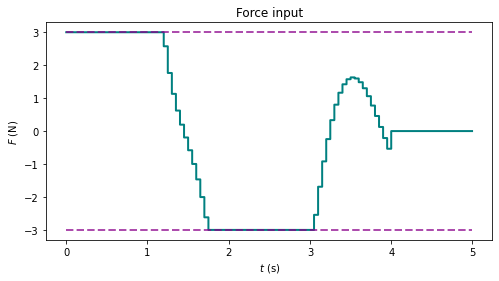

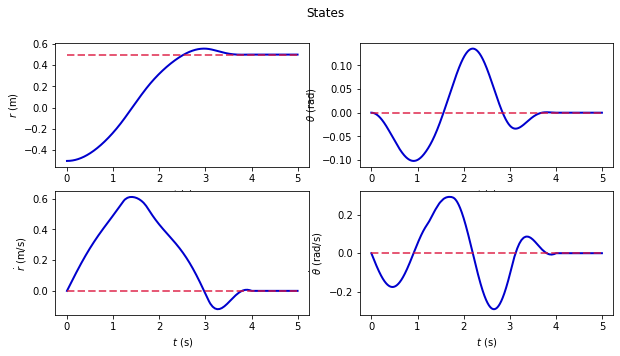

In [14]:
F_max = 3.0

F_opt = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True, F_max=F_max)
x_sim, u_sim = simulate_crane(x_0, F_opt)
plot_results(x_sim, u_sim, F_max=F_max)
HTML(show_animation().to_jshtml())

From the first plot we see that the force is restricted to $[-3,3]$, while still achieving the main goal of reaching the target!

***

### Adding state constraints:
Now you may ask, can we do the same with the state variables? Yes, we can! Eg. what if we want to limit the angle $\theta$ as well? We can write the constraint like this:
$$-\theta_{\textrm{max}} \leq \theta \leq \theta_{\textrm{max}},$$
and say we for instance want to limit the angle to $\theta_{\textrm{max}} = 4 \ \textrm{deg}$. Let's run another example with this constraint added (instead of the input constraint):

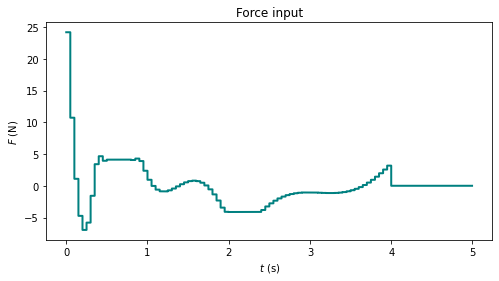

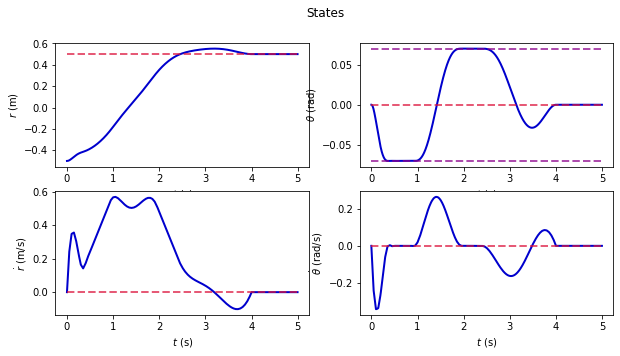

In [15]:
theta_max = np.deg2rad(4)

F_opt = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True, theta_max=theta_max)
x_sim, u_sim = simulate_crane(x_0, F_opt)
plot_results(x_sim, u_sim, theta_max=theta_max)
HTML(show_animation().to_jshtml())

Nice! From the top right plot of $\theta$ we see that the angle of the crane pendulum stays within the specified limits.

That's all! Feel free to play around with the above-mentioned parameters to see how it affects the motion of the pendulum and cart. Also, please revisit the above learning goals and try thinking about what you've learned 😊 